In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import random

# Modelado tradicional
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Visualización
import matplotlib.pyplot as plt

# Redes neuronales (Keras/Tensorflow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Bidirectional
from sklearn.preprocessing import MinMaxScaler

# Control de warnings
import warnings
warnings.filterwarnings("ignore")


from datetime import timedelta


# Semilla fija para reproducibilidad
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Asegurar determinismo (si está disponible)
try:
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
except:
    pass



C:\Users\Alejo\anaconda3\envs\sp500\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:

# Cargar el archivo CSV
relative_path = os.path.join("processed_files", "sp500_historico_normalized.csv")
df = pd.read_csv(relative_path, parse_dates=['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Asegurar tipos numéricos correctos
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=['Close', 'High', 'Low', 'Open', 'Volume'], inplace=True)
df = df.astype({col: 'float32' for col in ['Close', 'High', 'Low', 'Open', 'Volume']})

# Feature engineering: se calculan con información hasta t (inclusive)
df['ma_5'] = df['Close'].rolling(window=5).mean()
df['std_5'] = df['Close'].rolling(window=5).std()
df['momentum_5'] = df['Close'] - df['Close'].shift(5)

# Desplazar el objetivo (Close de t+1)
df['target_close_t+1'] = df['Close'].shift(-1)

# Eliminar nulos generados por rolling y shift
df.dropna(inplace=True)

# Definir variables de entrada y salida
feature_cols = ['Open', 'High', 'Low', 'Volume', 'ma_5', 'std_5', 'momentum_5']
X = df[feature_cols]
y = df['target_close_t+1']

# Separar en train/test conservando orden temporal
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Modelos Tradicionales

In [3]:


# 1. Definir modelos compatibles con pipeline
models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge())]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso())]),
    'BayesianRidge': Pipeline([('scaler', StandardScaler()), ('model', BayesianRidge())]),
    'DecisionTree': Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=42))]),
    'RandomForest': Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=100, random_state=42))]),
    'HistGradientBoosting': Pipeline([('scaler', StandardScaler()), ('model', HistGradientBoostingRegressor(random_state=42))]),
}

# 2. Crear diccionario de resultados
results_trad = {}

# 3. Entrenamiento y evaluación de modelos tradicionales
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results_trad[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# 4. Evaluar XGBoost por separado (fuera del Pipeline)
scaler_xgb = StandardScaler()
X_train_scaled_xgb = scaler_xgb.fit_transform(X_train)
X_test_scaled_xgb = scaler_xgb.transform(X_test)

xgb = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
xgb.fit(X_train_scaled_xgb, y_train)
y_pred_xgb = xgb.predict(X_test_scaled_xgb)

results_trad['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'MSE': mean_squared_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb)
}

# 5. Mostrar resultados ordenados por RMSE
df_results_trad = pd.DataFrame(results_trad).T.sort_values(by='RMSE')
print(df_results_trad)


                              MAE           MSE         RMSE        R2
LinearRegression        31.371927  1.947929e+03    44.135347  0.997689
BayesianRidge           31.374823  1.948086e+03    44.137127  0.997689
Ridge                   32.333801  2.048099e+03    45.255930  0.997570
Lasso                   36.751123  2.545122e+03    50.449206  0.996980
RandomForest          1175.639018  2.206833e+06  1485.541240 -1.618272
HistGradientBoosting  1206.645029  2.285338e+06  1511.733424 -1.711414
XGBoost               1215.264282  2.311642e+06  1520.408416 -1.742621
DecisionTree          1248.458371  2.391605e+06  1546.481562 -1.837493


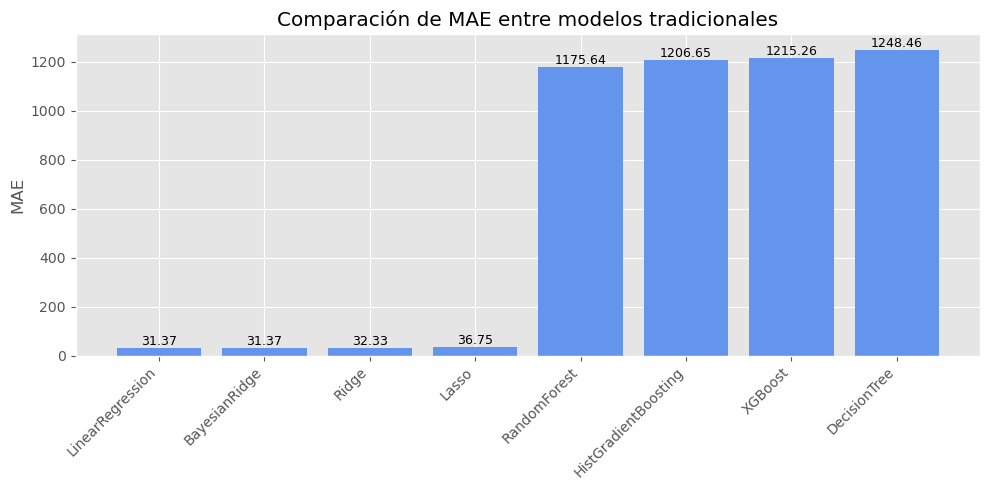

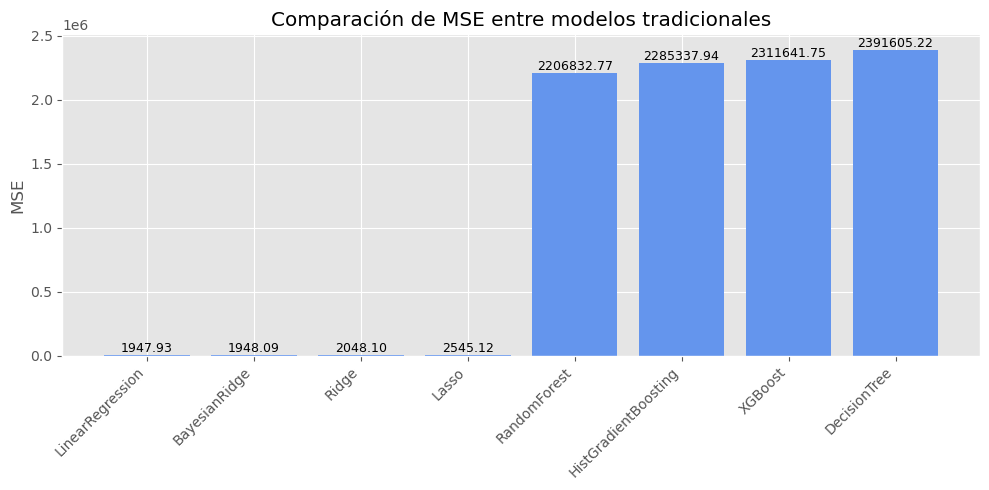

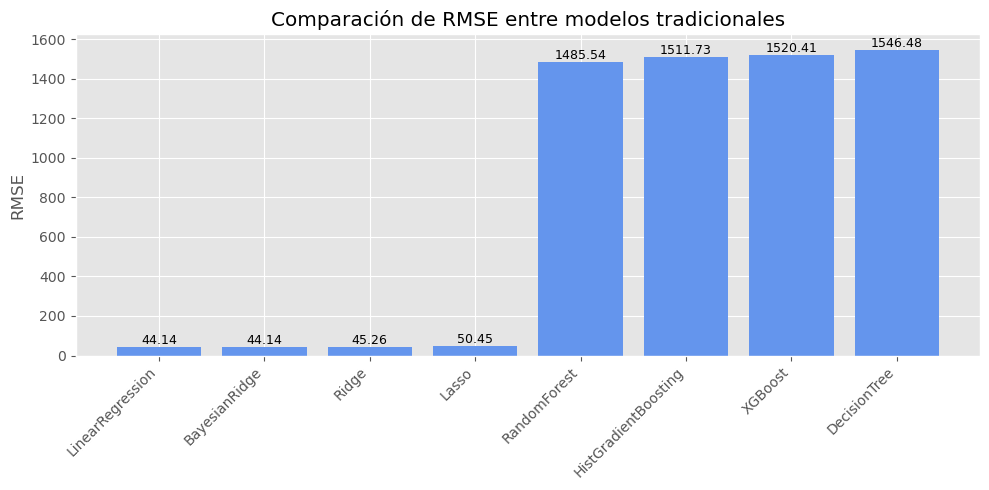

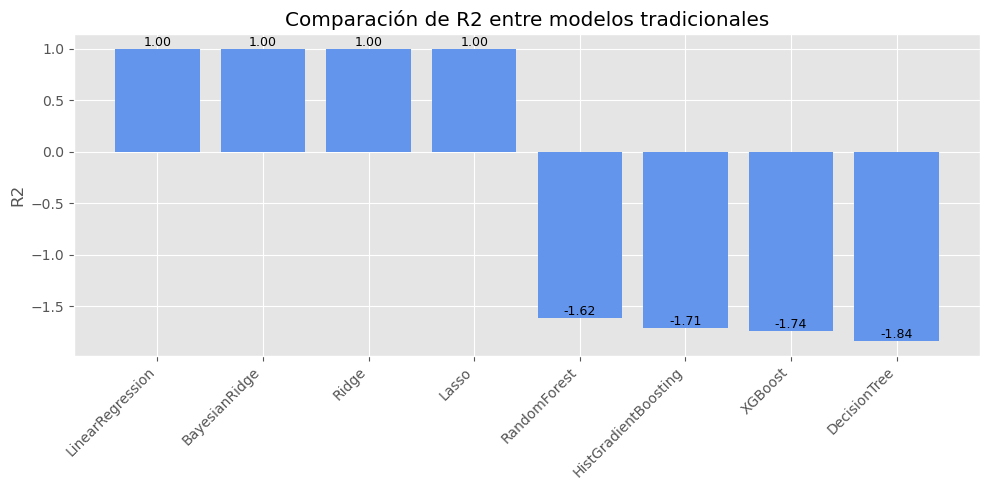

In [4]:


# Estilo válido (opcional: puedes comentar esta línea si no quieres ningún estilo aplicado)
plt.style.use('ggplot')  # O puedes usar 'default', 'classic', 'bmh', etc.

# Lista de métricas a graficar
metrics = ['MAE', 'MSE', 'RMSE', 'R2']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    bars = plt.bar(df_results_trad.index, df_results_trad[metric], color='cornflowerblue')
    plt.title(f'Comparación de {metric} entre modelos tradicionales')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

    # Etiquetas de valor encima de las barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()


# Redes Neuoranles

In [5]:
# Reescalado
scaler_nn = MinMaxScaler()
X_scaled = scaler_nn.fit_transform(X)
y_scaled = y.values.reshape(-1, 1)

# División
X_train_nn = X_scaled[:train_size]
X_test_nn = X_scaled[train_size:]
y_train_nn = y_scaled[:train_size]
y_test_nn = y_scaled[train_size:]

# Secuencias para RNNs
X_train_seq = X_train_nn.reshape((X_train_nn.shape[0], X_train_nn.shape[1], 1))
X_test_seq = X_test_nn.reshape((X_test_nn.shape[0], X_test_nn.shape[1], 1))

# Función de evaluación
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test).flatten()
    y_test = y_test.flatten()
    return {
        'Modelo': nombre,
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

# Lista de resultados
resultados_nn = []

# 1. ANN
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_ann.compile(optimizer='adam', loss='mse')
model_ann.fit(X_train_nn, y_train_nn, epochs=50, batch_size=32, verbose=0)
resultados_nn.append(evaluar_modelo("ANN", model_ann, X_test_nn, y_test_nn))

# 2. LSTM
model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_seq, y_train_nn, epochs=50, batch_size=32, verbose=0)
resultados_nn.append(evaluar_modelo("LSTM", model_lstm, X_test_seq, y_test_nn))

# 3. GRU
model_gru = Sequential([
    GRU(64, input_shape=(X_train_seq.shape[1], 1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train_seq, y_train_nn, epochs=50, batch_size=32, verbose=0)
resultados_nn.append(evaluar_modelo("GRU", model_gru, X_test_seq, y_test_nn))

# 4. BiLSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train_seq.shape[1], 1)),
    Dense(1)
])
model_bilstm.compile(optimizer='adam', loss='mse')
model_bilstm.fit(X_train_seq, y_train_nn, epochs=50, batch_size=32, verbose=0)
resultados_nn.append(evaluar_modelo("BiLSTM", model_bilstm, X_test_seq, y_test_nn))

# 5. CNN + LSTM
model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1)
])
model_cnn_lstm.compile(optimizer='adam', loss='mse')
model_cnn_lstm.fit(X_train_seq, y_train_nn, epochs=50, batch_size=32, verbose=0)
resultados_nn.append(evaluar_modelo("CNN+LSTM", model_cnn_lstm, X_test_seq, y_test_nn))

# 6. SimpleRNN
model_simplernn = Sequential([
    SimpleRNN(64, input_shape=(X_train_seq.shape[1], 1)),
    Dense(1)
])
model_simplernn.compile(optimizer='adam', loss='mse')
model_simplernn.fit(X_train_seq, y_train_nn, epochs=50, batch_size=32, verbose=0)
resultados_nn.append(evaluar_modelo("SimpleRNN", model_simplernn, X_test_seq, y_test_nn))

# Mostrar resultados
df_results_nn = pd.DataFrame(resultados_nn).set_index('Modelo').sort_values(by='RMSE')
print(df_results_nn)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
                   MAE           MSE         RMSE         R2
Modelo                                                      
ANN         180.723129  5.588302e+04   236.395904   0.933698
BiLSTM     2707.817871  8.175132e+06  2859.218687  -8.699293
GRU        3169.697510  1.088984e+07  3299.975757 -11.920130
LSTM       3170.366699  1.089408e+07  3300.618275 -11.925161
SimpleRNN  3171.418945  1.090076e+07  3301.629446 -11.933082
CNN+LSTM   3302.591064  1.174997e+07  3427.822341 -12.940617


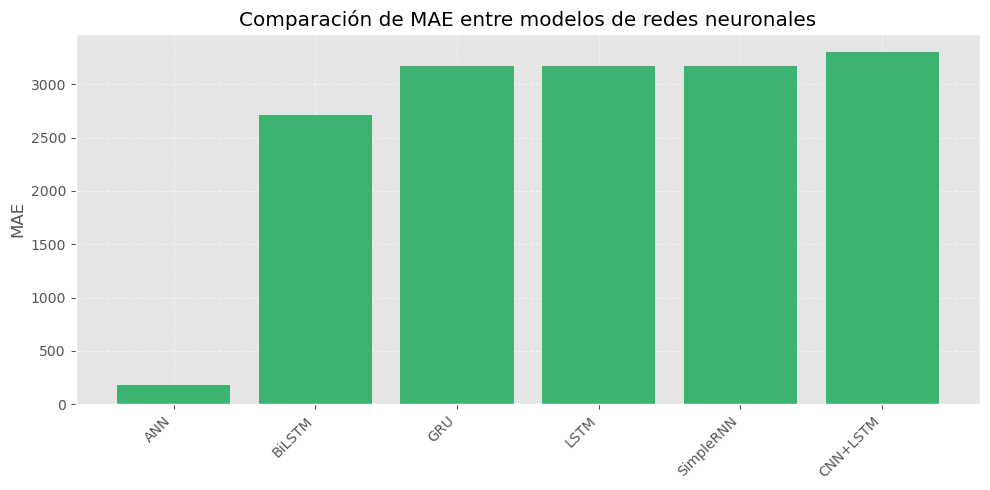

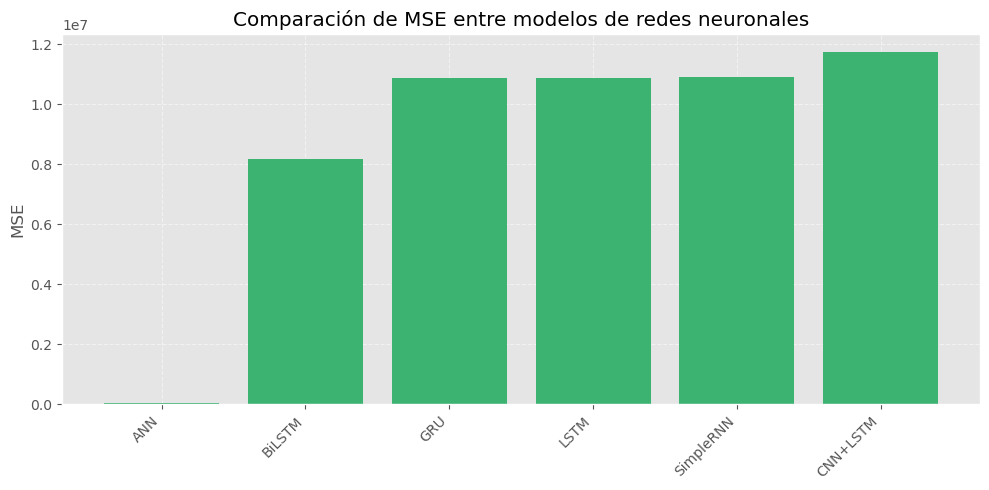

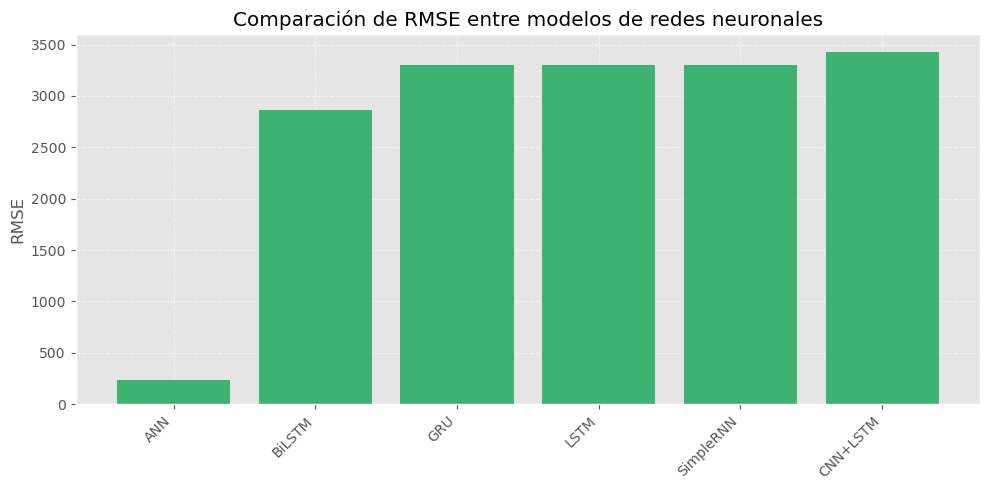

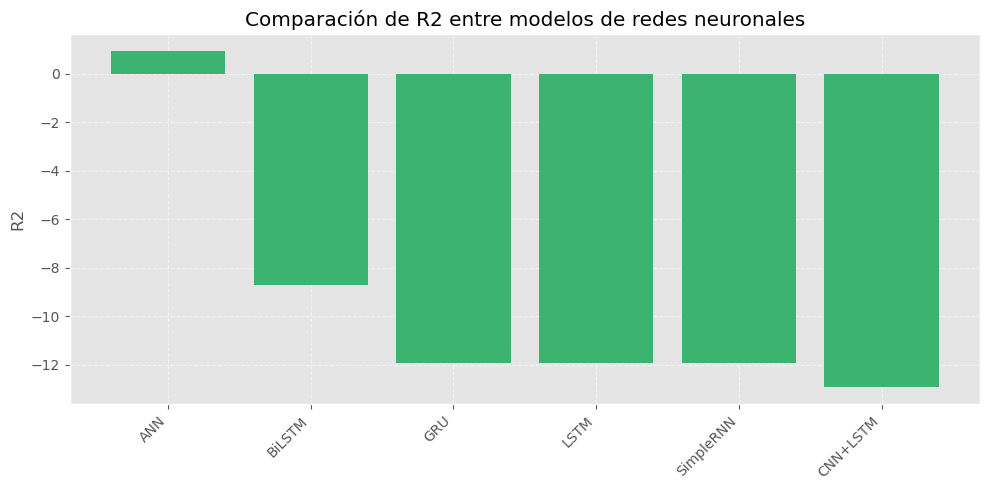

In [6]:
# Visualización de resultados para cada métrica
metrics = ['MAE', 'MSE', 'RMSE', 'R2']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(df_results_nn.index, df_results_nn[metric], color='mediumseagreen')
    plt.title(f'Comparación de {metric} entre modelos de redes neuronales')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


📋 Top 4 modelos con mejor rendimiento general (al menos uno por tipo):

                      MAE        MSE     RMSE     R2          Tipo
LinearRegression  31.3719  1947.9288  44.1353 0.9977   Tradicional
BayesianRidge     31.3748  1948.0860  44.1371 0.9977   Tradicional
Ridge             32.3338  2048.0992  45.2559 0.9976   Tradicional
ANN              180.7231 55883.0234 236.3959 0.9337  Red Neuronal


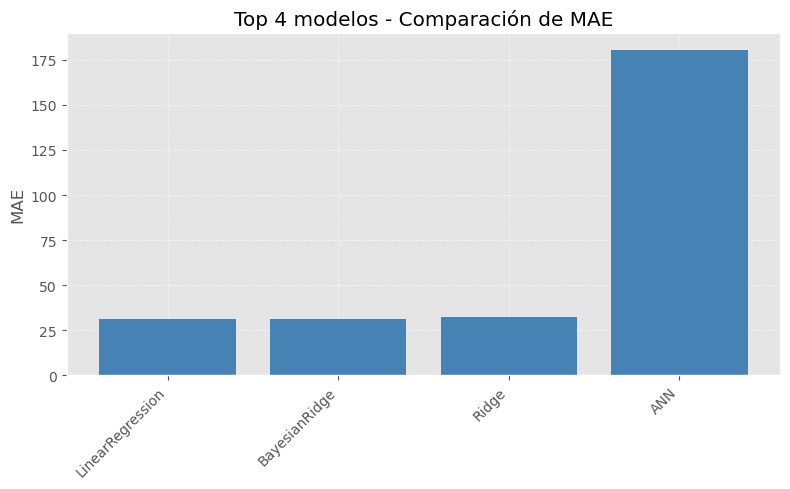

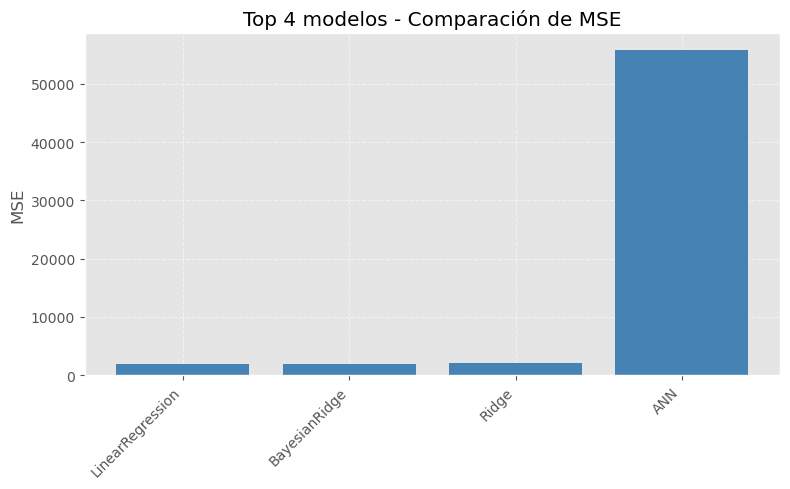

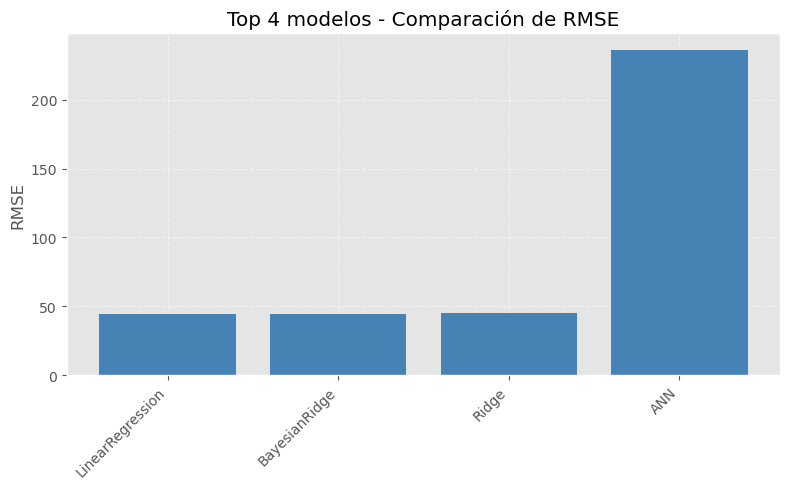

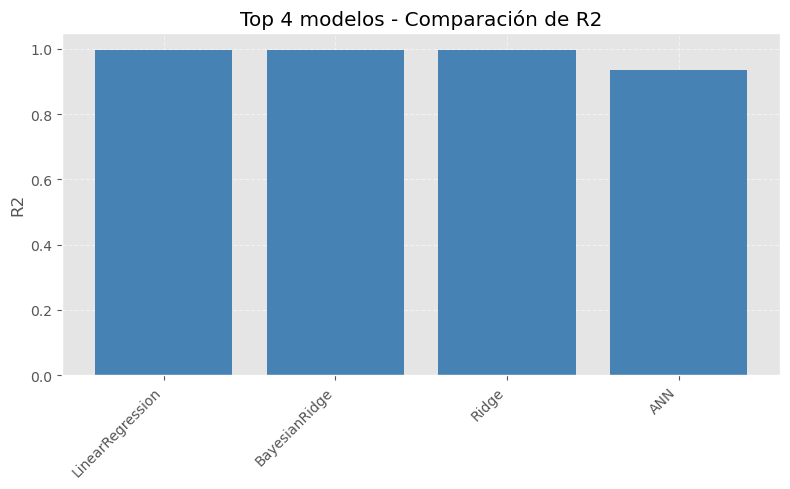

In [7]:
# Combinar resultados
df_combined_results = pd.concat([df_results_trad, df_results_nn])
df_combined_results['Tipo'] = ['Tradicional'] * len(df_results_trad) + ['Red Neuronal'] * len(df_results_nn)

# Seleccionar el mejor de cada tipo
mejor_trad = df_combined_results[df_combined_results['Tipo'] == 'Tradicional'].sort_values(by='RMSE').iloc[0:1]
mejor_nn = df_combined_results[df_combined_results['Tipo'] == 'Red Neuronal'].sort_values(by='RMSE').iloc[0:1]

# Eliminar duplicados si por casualidad son iguales (por precaución)
df_sin_mejores = df_combined_results.drop(index=[mejor_trad.index[0], mejor_nn.index[0]])

# Seleccionar los siguientes mejores modelos sin repetir tipo
otros_mejores = df_sin_mejores.sort_values(by='RMSE').head(2)

# Combinar todo para los top 4 (asegurando presencia de ambos tipos)
top4_models = pd.concat([mejor_trad, mejor_nn, otros_mejores]).sort_values(by='RMSE')

# Mostrar resultados en texto plano
print("📋 Top 4 modelos con mejor rendimiento general (al menos uno por tipo):\n")
print(top4_models.to_string(float_format="%.4f"))

# Graficar comparativamente
for metric in ['MAE', 'MSE', 'RMSE', 'R2']:
    plt.figure(figsize=(8, 5))
    plt.bar(top4_models.index, top4_models[metric], color='steelblue')
    plt.title(f'Top 4 modelos - Comparación de {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


In [8]:

print("\n🔮 PREDICCIÓN REAL PARA EL PRÓXIMO DÍA\n")

# Última fecha registrada en el dataset (30 de diciembre de 2024)
fecha_entrada = df.index[-1]  # Esta es la fecha de la última fila disponible
fecha_prediccion = fecha_entrada + timedelta(days=1)

# Último vector de entrada
ultimo_vector = X.iloc[[-1]]

print(f"📅 Fecha de los datos usados como entrada: {fecha_entrada.date()}")
print(f"📅 Fecha estimada de la predicción: {fecha_prediccion.date()}\n")

print("📈 Datos de entrada usados para predecir:")
display(ultimo_vector)

# ANN - Escalar el vector y predecir
input_ann_scaled = scaler_nn.transform(ultimo_vector.values)
y_pred_ann = model_ann.predict(input_ann_scaled)
print(f"🤖 ANN (predicción del cierre para el {fecha_prediccion.date()}): {y_pred_ann[0][0]:.2f}")

# Tradicionales (solo los mejores modelos, excepto ANN)
for nombre in top4_models.index:
    if nombre == 'ANN':
        continue
    modelo = models[nombre]  # Pipeline ya entrenado
    y_pred = modelo.predict(ultimo_vector.values)
    print(f"📊 {nombre} (predicción del cierre para el {fecha_prediccion.date()}): {y_pred[0]:.2f}")



🔮 PREDICCIÓN REAL PARA EL PRÓXIMO DÍA

📅 Fecha de los datos usados como entrada: 2024-12-27
📅 Fecha estimada de la predicción: 2024-12-28

📈 Datos de entrada usados para predecir:


,Open,High,Low,Volume,ma_5,std_5,momentum_5
Date,,,,,,,
2024-12-27,6006.169922,6006.169922,5932.950195,3.159610e+09,5990.67793,47.13304,103.759766


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
🤖 ANN (predicción del cierre para el 2024-12-28): 5468.62
📊 LinearRegression (predicción del cierre para el 2024-12-28): 5965.99
📊 BayesianRidge (predicción del cierre para el 2024-12-28): 5966.18
📊 Ridge (predicción del cierre para el 2024-12-28): 5989.67
